### Experiment 1: agent A generates query and "ground truth" (GT)

In this asymmetric two-model configuration, we evaluate how well Agent B aligns with Agent A's intent, treating A's generated query and description as the ground truth (GT), but in reality it's initial understanding of its own query that is being evaluated. This setup embodies the Recursive Consciousness (RC) framework's principle of a forgetful subsystem (B) reconstructing "axioms" (A's intent) through recursive probing, with agent M mediating questions to refine understanding toward an epistemic fixpoint (minimal semantic divergence).

Agent A generates a query $Q$ and initial understanding $s_{\text{GT}}$, while Agent B interprets $Q$ to produce its own understanding. Agent F (facilitator) generates a set of N questions (potentially dependent on $Q$) and sends them to both agents. Responses from B are used to iteratively refine its alignment to $s_{\text{GT}}$, with computation focusing on B's convergence. Querying A maintains symmetry for consistency checks or role-swaps but is optional for the core evaluation, as A's responses reinforce the fixed GT. The goal is to measure B's alignment to A's GT via a simplified understanding equation, quantifying interpretive fidelity in line with RC's lossy translations ($I \dashv M$).

#### Workflow

* **A Generates Initial Query and its Understanding:** Agent A produces $Q$ and $s_{\text{GT}}$ (extended description of intent).
* **B Interprets Q:** Agent B generates its initial understanding of $Q$.
* **M Generates Questions:** M creates N adaptive questions based on $Q$ (e.g., intent clarification, accuracy probes).
* **Query Both Agents:** Send questions to A and B; append responses to their respective histories.
* **Iterative Refinement and Termination:** For each iteration (starting from 2), compute U on current understandings; terminate early if $\Delta U < \epsilon$ (minimal change) or at max N.
* **Compute Understanding:** Use B's responses vs A's GT for the simplified U(AB); optionally compute for symmetry.
* **Role-Swap:** Repeat with B as GT generator and A as interpreter for U(BA), highlighting non-commutativity ($\Phi_{A\to B} \neq \Phi_{B\to A}$).

#### RC Understanding Equation $U_{\text{mutual}}$

The mutual understanding metric quantifies the interpretive fidelity between two agents' understandings, incorporating semantic distance and recency-weighted contributions from their histories. The equation is defined as follows:

$$
U_{\text{mutual}}(s_A, s_B) = \sum_{n=1}^N w_n \left[ (1 - D_{\text{JS}}(P^{(n)}_A \| P^{(n)}_B)) \cdot (1 - d^{(n)}_{\text{sem}}) \cdot \sqrt{\kappa^{(n)}_A \kappa_B^{(n)}} \right]
$$

Where:

weights: $w_n = \frac{2n}{N(N+1)}$ (linear recency, summing to 1);

$$
D_{\text{JS}}(P_A \| P_B) = \frac{1}{2} \left[ D_{\text{KL}}(P_A \| M) + D_{\text{KL}}(P_B \| M) \right]
$$
where $M = \frac{1}{2}(P_A + P_B)$;

$$
d_{\text{sem}}(s_A, s_B) = \frac{1 - \cos(E(s_A), E(s_B))}{2} = \sin^2(\theta/2)
$$

where $\theta = \arccos(\langle \hat{E}(s_A), \hat{E}(s_B) \rangle)$;

$$
\kappa^{(n)}_{A/B} = \exp\left( - \|s^{(n)}_{A/B} - s^{(n-1)}_{A/B}\| \right)
$$

with the geometric mean $\sqrt{\kappa_A^{(n)} \kappa_B^{(n)}}$ symmetrizing loops and bounding the Lipschitz constant.


In [1]:
import openai
import numpy as np
from typing import List, Tuple
from dotenv import load_dotenv
import os
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_KEY

# Set to None to use local AI models, OpenAI API key is still required but will be used ony for embeddings model
# OPENAI_API_KEY = None

LOCAL_AI_API_URL = "http://localhost:8080/v1"

LLM_MODEL_A1 = "gpt-4.1-mini"
LLM_MODEL_A2 = "o1"
LLM_MODEL_A3 = "o4-mini"
LLM_MODEL_A4 = "o3-mini"
LLM_MODEL_A5 = "o3"
LLM_MODEL_A6 = "gpt-4.1"
LLM_MODEL_LOCAL = "local"

EMBEDDING_MODEL = "text-embedding-3-large"

MAX_ITERATIONS = 10
MIN_ITERATIONS = 5
EPSILON = 0.005

In [3]:
# Embed using OpenAI API
def embed(text: str) -> np.ndarray:
    try:
        response = openai.embeddings.create(
            model=EMBEDDING_MODEL,
            input=text
        )
        return np.array(response.data[0].embedding)
    except Exception as e:
        print(f"Error embedding text: {e}")
        return np.array([])  # Return empty array on error

In [4]:
# Chat with error handling
def chat(model: str, messages: List[dict], temperature: float = 0.7) -> str:
    try:
        response = openai.chat.completions.create(
            model=model,
            messages=messages
            # temperature=temperature,
            # max_tokens=200
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API error: {e}")
        time.sleep(5)  # Rate limit backoff
        return ""  # Fallback

In [5]:
def chat_local(model: str, messages: List[dict], base_url: str = LOCAL_AI_API_URL, temperature: float = 0.7) -> str:
    try:
        client = openai.Client(base_url=base_url)

        response = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=300
            # temperature=temperature
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Local API error: {e}")
        time.sleep(5)  # Rate limit backoff
        return ""  # Fallback

In [ ]:
def cosine_sim(emb1: np.ndarray, emb2: np.ndarray) -> float:
    # Handle empty arrays (error case)
    if emb1.size == 0 or emb2.size == 0 or emb1.shape != emb2.shape:
        raise ValueError("Embeddings must be non-empty and of the same shape in cosine_sim")

    # Calculate cosine similarity
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)

    # Handle zero vectors
    if norm1 == 0 or norm2 == 0:
        return 1.0

    cos = np.dot(emb1, emb2) / (norm1 * norm2)
    return cos

# Helper function for softmax with better numerical stability
def softmax(x):
    """Compute softmax values for array x with enhanced numerical stability."""
    if len(x) == 0:
        return np.array([])

    # Enhanced numerical stability
    x_shifted = x - np.max(x)
    exp_x = np.exp(np.clip(x_shifted, -500, 500))  # Prevent overflow/underflow
    sum_exp = np.sum(exp_x)

    if sum_exp == 0 or not np.isfinite(sum_exp):
        # Fallback to uniform distribution
        return np.ones(len(x)) / len(x)

    return exp_x / sum_exp

# Improved Mutual Understanding with better error handling and interpretation
def jensen_shannon(single_emb, multi_emb):
    """Calculate Jensen-Shannon divergence as proxy for mutual understanding."""

    if single_emb.size == 0 or multi_emb.size == 0 or single_emb.shape != multi_emb.shape:
        raise ValueError("Embeddings must be non-empty and have matching shapes in jensen_shannon.")

    try:
        # Normalize embeddings to same scale
        single_norm = single_emb / (np.linalg.norm(single_emb) + 1e-10)
        multi_norm = multi_emb / (np.linalg.norm(multi_emb) + 1e-10)

        # Create pseudo-distributions via softmax
        p_s = softmax(single_norm * 10)  # Scale for better separation
        p_m = softmax(multi_norm * 10)

        # Compute Jensen-Shannon divergence with smoothing
        epsilon = 1e-10
        m = 0.5 * (p_s + p_m)
        kl_sm = np.sum(p_s * np.log((p_s + epsilon) / (m + epsilon)))
        kl_ms = np.sum(p_m * np.log((p_m + epsilon) / (m + epsilon)))
        divergence = 0.5 * (kl_sm + kl_ms)
        return max(0, divergence)  # Ensure non-negative

    except Exception as e:
        raise ValueError(f"Error in jensen_shannon calculation: {e}.")

def semantic_distance(emb1: np.ndarray, emb2: np.ndarray) -> float:
    cos = cosine_sim(emb1, emb2)
    # Compute d_sem = (1 - cos) / 2 = sin^2(theta/2)
    return (1 - cos) / 2

def kappa(dist_A: float, dist_B: float) -> float:
    return np.exp(-(dist_A + dist_B) / 2)

def mutual_understanding_advanced(history_a: List[np.ndarray], history_b: List[np.ndarray]) -> float:
    if len(history_a) == 0 or len(history_b) == 0 or len(history_a) != len(history_b):
        raise ValueError("History lists must be of the same length and non-empty in mutual_understanding_advanced.")

    total = 0.0
    N = len(history_a)  # Number of iterations
    denom = N * (N + 1)
    for n in range(1, N + 1):  # n from 1 to N
        i = n - 1  # 0-based index
        if history_a[i].size == 0 or history_b[i].size == 0 or history_a[i].shape != history_b[i].shape:
            raise ValueError("History entries must be non-empty in mutual_understanding_advanced.")

        divergence = jensen_shannon(history_a[i], history_b[i])
        align_prob = 1 - divergence
        d_sem = semantic_distance(history_a[i], history_b[i])
        align_sem = 1 - d_sem
        if n > 1:
            dist_prev_A = semantic_distance(history_a[i], history_a[i-1])
            dist_prev_B = semantic_distance(history_b[i], history_b[i-1])
            k = kappa(dist_prev_A, dist_prev_B)
        else:
            k = 1.0  # For n=1: No previous iteration, set stability factor to 1.0
        w_n = (2 * n) / denom
        total += w_n * (align_prob * align_sem * k)

    return total

In [7]:
def create_gt_prompt(topic: str = None) -> str:
    """Create the ground truth generation prompt."""
    base_prompt = "Generate a complex, thought-provoking question and provide your detailed understanding of what this question is asking for. Format your response as:\nQUESTION: [your question]\nUNDERSTANDING: [detailed explanation of the question's intent, context, and what constitutes a good answer]"

    if topic:
        return f"Generate a complex question about {topic} and provide your detailed understanding of what this question is asking for. Format your response as:\nQUESTION: [your question]\nUNDERSTANDING: [detailed explanation of the question's intent, context, and what constitutes a good answer]"

    return base_prompt

def create_moderator_prompt(
    s_GT: str,
    Q: str,
    N: int = MAX_ITERATIONS
) -> str:
    """Create the moderator prompt for generating probing questions."""

    prompt = f"""Based on this question: "{Q}",

and its initial understanding by the entity posing this question: "{s_GT}"

Generate {N} unique probing questions that would help reveal the intent and understanding of the question.
Focus on areas where the interpretations might differ or need clarification.
Your output must only include {N} questions, one question per line, nothing else.
"""
    return prompt

In [8]:
def run_iterative_questioning_phase(
    gt_agent_model: str,
    interpreter_model: str,
    moderator_model: str,
    Q: str,
    s_GT: str,
    gt_agent_name: str,
    interpreter_name: str,
    max_iterations: int,
    epsilon: float
) -> dict:
    """
    Run one phase of the iterative questioning process.

    Args:
        gt_agent_model: Model for the GT-generating agent
        interpreter_model: Model for the interpreting agent
        moderator_model: Model for the moderator (question generator)
        Q: The initial question
        s_GT: The GT agent's understanding
        gt_agent_name: Name of GT agent ("A" or "B")
        interpreter_name: Name of interpreter agent ("B" or "A")
        max_iterations: Maximum iterations
        epsilon: Convergence threshold
        topic: Optional topic for context

    Returns:
        dict: Phase results with understanding, iterations, and conversation history
    """
    print(f"\n🔄 PHASE: Agent {gt_agent_name} as Ground Truth Generator")
    print("-" * 40)

    delta_U = 0.0

    # Step 1: Initial setup
    interpreter_initial_prompt = f"Question: {Q}\n\nProvide your understanding of what this question is asking for, including context, intent, and what would constitute a good answer. Do not say anything else."
    if interpreter_model == LLM_MODEL_LOCAL:
        interpreter_initial_response = chat_local(interpreter_model, [{"role": "user", "content": interpreter_initial_prompt}])
    else:
        interpreter_initial_response = chat(interpreter_model, [{"role": "user", "content": interpreter_initial_prompt}])
    print(f"\n🤖 Agent {interpreter_name}'s initial interpretation:")
    print(f"   {interpreter_initial_response[:100]}...")

    # Initialize conversation histories
    history_gt = [{"role": "user", "content": Q}, {"role": "assistant", "content": s_GT}]
    history_interpreter = [{"role": "user", "content": Q}, {"role": "assistant", "content": interpreter_initial_response}]

    # Store embeddings for iterations - separate tracking for question responses vs understanding
    emb_gt = embed(s_GT)  # GT agent's understanding
    emb_interpreter = embed(interpreter_initial_response)
    iter_emb_gt_responses = [emb_gt]  # GT agent's responses to questions
    iter_emb_interpreter_responses = [iter_emb_gt_responses]  # Interpreter's responses to questions

    # Track understanding evolution separately
    iter_emb_gt_understanding = [emb_gt]  # GT agent's understanding evolution
    iter_emb_interpreter_understanding = [emb_interpreter]  # Interpreter's understanding evolution

    conversation_history = [{
        'iteration': 0,
        f'{gt_agent_name}_understanding': s_GT,
        f'{interpreter_name}_understanding': interpreter_initial_response,
        'question': Q
    }]

    # Iterative refinement
    prev_U = 0.0
    m_prompt = create_moderator_prompt(
        s_GT=s_GT,
        Q=Q,
        N=max_iterations
    )
    questions = chat(moderator_model, [{"role": "user", "content": m_prompt}]).strip()
    questions = questions.splitlines()
    # delete any empty questions
    questions = [q.strip() for q in questions if q.strip() != ""]
    print(f"❓ Moderator generated {len(questions)} questions.")
    max_iterations = min(max_iterations, len(questions))

    for iteration in range(1, max_iterations + 1):
        print(f"\n🔄 Iteration {iteration}")

        # Moderator Generates One Question per iteration
        question = questions[iteration - 1]
        # Query both agents with the single question
        iteration_data = {
            'iteration': iteration,
            'question': question,
            'U': 0.0,  # Placeholder for understanding value
            f'{gt_agent_name}_response': "",
            f'{interpreter_name}_response': "",
            f'{gt_agent_name}_understanding': "",
            f'{interpreter_name}_understanding': "",
        }

        # Query GT agent - their response to this specific question
        history_gt.append({"role": "user", "content": question})
        if gt_agent_model == LLM_MODEL_LOCAL:
            gt_response_to_question = chat_local(gt_agent_model, history_gt)
        else:
            gt_response_to_question = chat(gt_agent_model, history_gt)
        history_gt.append({"role": "assistant", "content": gt_response_to_question})
        iteration_data[f'{gt_agent_name}_response'] = gt_response_to_question

        # Query interpreter - their response to the same specific question
        history_interpreter.append({"role": "user", "content": question})
        if interpreter_model == LLM_MODEL_LOCAL:
            interpreter_response_to_question = chat_local(interpreter_model, history_interpreter)
        else:
            interpreter_response_to_question = chat(interpreter_model, history_interpreter)
        history_interpreter.append({"role": "assistant", "content": interpreter_response_to_question})
        iteration_data[f'{interpreter_name}_response'] = interpreter_response_to_question

        print(f"   {gt_agent_name}: {gt_response_to_question[:80]}...")
        print(f"   {interpreter_name}: {interpreter_response_to_question[:80]}...")

        # Store embeddings of responses to the SAME question
        iter_emb_gt_responses.append(embed(gt_response_to_question))
        iter_emb_interpreter_responses.append(embed(interpreter_response_to_question))

        prompt = f"Based on the above dialog and discussing question:\n{Q}\n\nSummarize your current understanding of '{Q}'.\n\nYour response must include only the summary of understanding, nothing else."

        # Update understanding summaries (for stability tracking)
        history_gt.append({"role": "user", "content": prompt})
        if gt_agent_model == LLM_MODEL_LOCAL:
            gt_updated_response = chat_local(gt_agent_model, history_gt)
        else:
            gt_updated_response = chat(gt_agent_model, history_gt)
        history_gt.append({"role": "assistant", "content": gt_updated_response})
        iteration_data[f'{gt_agent_name}_understanding'] = gt_updated_response

        history_interpreter.append({"role": "user", "content": prompt})
        if interpreter_model == LLM_MODEL_LOCAL:
            interpreter_updated_response = chat_local(interpreter_model, history_interpreter)
        else:
            interpreter_updated_response = chat(interpreter_model, history_interpreter)
        history_interpreter.append({"role": "assistant", "content": interpreter_updated_response})
        iteration_data[f'{interpreter_name}_understanding'] = interpreter_updated_response

        # Store embeddings of understanding evolution (for stability calculation)
        iter_emb_gt_understanding.append(embed(gt_updated_response))
        iter_emb_interpreter_understanding.append(embed(interpreter_updated_response))

        # Compute U (simplified version) - comparing responses to the same questions
        current_U = 0.0
        if iteration >= 1:
            current_U = mutual_understanding_advanced(
                iter_emb_gt_understanding,
                iter_emb_interpreter_understanding
            )
            iteration_data['U'] = current_U
            print(f"   💯 U_simplified at iteration {iteration}: {current_U:.4f}")

        conversation_history.append(iteration_data)

        # Check for convergence (only after min MIN_ITERATIONS)
        if prev_U > 0:
            d = abs(current_U - prev_U)
            print(f"   📈 ΔU: {d:.6f} (threshold: {epsilon})")
            if iteration >= MIN_ITERATIONS and d  < epsilon and delta_U < epsilon:
                print(f"   ✅ Converged at iteration {iteration}")
                break
            delta_U = d
        prev_U = current_U

    final_U = current_U
    print(f"\n📊 Phase Results: U_{gt_agent_name}→{interpreter_name} = {final_U:.4f} in {iteration} iterations")

    return {
        'U': final_U,
        'iterations': iteration,
        'conversation_history': conversation_history
    }


In [9]:
def generate_gt_and_extract(model: str, topic: str = None) -> tuple[str, str, str]:
    """
    Generate GT response and extract Q and s_GT.

    Returns:
        tuple: (full_response, Q, s_GT)
    """
    gt_prompt = create_gt_prompt(topic)
    if model == LLM_MODEL_LOCAL:
        gt_response = chat_local(model, [{"role": "user", "content": gt_prompt}])
    else:
        gt_response = chat(model, [{"role": "user", "content": gt_prompt}])
    print(f"   {gt_response[:100]}...")

    # Extract Q and s_GT
    lines = gt_response.split('\n')
    Q = ""
    s_GT = ""
    for line in lines:
        if line.startswith("QUESTION:"):
            Q = line.replace("QUESTION:", "").strip()
        elif line.startswith("UNDERSTANDING:"):
            s_GT = line.replace("UNDERSTANDING:", "").strip()

    if not Q or not s_GT:
        Q = gt_response
        s_GT = gt_response

    return gt_response, Q, s_GT

In [10]:
def experiment_workflow(model_A: str, model_B: str, model_M: str, topic: str = None,
                       max_iterations: int = MAX_ITERATIONS, epsilon: float = EPSILON) -> dict:
    """
    Complete RC Understanding Equation workflow implementation.

    Args:
        model_A: Model name for Agent A
        model_B: Model name for Agent B
        model_M: Model name for Mediator M (question generator)
        topic: Optional topic to focus the experiment on
        max_iterations: Maximum number of iterations
        epsilon: Convergence threshold for early termination

    Returns:
        dict: Results containing understanding, iterations, and conversation histories
    """
    print("=" * 60)
    print("RECURSIVE CONSCIOUSNESS UNDERSTANDING EXPERIMENT")
    print("=" * 60)

    # Phase 1: A generates GT, B interprets
    print("\n📝 Agent A generates question and GT understanding...")

    gt_response_a, Q_a, s_GT_a = generate_gt_and_extract(model_A, topic)
    print(f"   Q: {Q_a}")
    print(f"   s_GT: {s_GT_a[:100]}...")

    # Run Phase 1
    phase1_results = run_iterative_questioning_phase(
        gt_agent_model=model_A,
        interpreter_model=model_B,
        moderator_model=model_M,
        Q=Q_a,
        s_GT=s_GT_a,
        gt_agent_name="A",
        interpreter_name="B",
        max_iterations=max_iterations,
        epsilon=epsilon
    )

    # Phase 2: B generates GT, A interprets
    print("\n📝 Agent B generates question and GT understanding...")

    gt_response_b, Q_b, s_GT_b = generate_gt_and_extract(model_B, topic)

    # Run Phase 2
    phase2_results = run_iterative_questioning_phase(
        gt_agent_model=model_B,
        interpreter_model=model_A,
        moderator_model=model_M,
        Q=Q_b,
        s_GT=s_GT_b,
        gt_agent_name="B",
        interpreter_name="A",
        max_iterations=max_iterations,
        epsilon=epsilon
    )

    # Compile final results
    results = {
        'Model A': model_A,
        'Model B': model_B,
        'Model M': model_M,
        'topic': topic,
        'gt_response_A': gt_response_a,  # Store full response for debugging
        'Q_A': Q_a,
        's_GT_A': s_GT_a,
        'gt_response_B': gt_response_b,  # Store full response for debugging
        'Q_B': Q_b,
        's_GT_B': s_GT_b,
        'U_AB': phase1_results['U'],
        'U_BA': phase2_results['U'],
        'iterations_AB': phase1_results['iterations'],
        'iterations_BA': phase2_results['iterations'],
        'conversation_history_AB': phase1_results['conversation_history'],
        'conversation_history_BA': phase2_results['conversation_history']
    }

    # Final summary
    print("\n" + "=" * 60)
    print("EXPERIMENT SUMMARY")
    print("=" * 60)
    print(f"🔄 U(A→B): {results['U_AB']:.4f} ({results['iterations_AB']} iterations)")
    print(f"🔄 U(B→A): {results['U_BA']:.4f} ({results['iterations_BA']} iterations)")
    print(f"🔄 Non-commutativity: |U(A→B) - U(B→A)| = {abs(results['U_AB'] - results['U_BA']):.4f}")

    if abs(results['U_AB'] - results['U_BA']) > epsilon:
        print("✨ Significant non-commutativity detected! Φ_{A→B} ≠ Φ_{B→A}")
    else:
        print("🤝 Approximate commutativity observed")

    return results

In [11]:
def run_default_experiment(topic: str = None,
                           gt_model: str = LLM_MODEL_A1,
                           interpreter_model: str = LLM_MODEL_A3) -> dict:
    """
    Run the RC Understanding Equation experiment with default models.

    Args:
        topic: Optional topic to focus the experiment on

    Returns:
        dict: Results from the experiment
    """
    return experiment_workflow(
        model_A=gt_model,                   # gpt-4.1-mini
        model_B=interpreter_model,          # o4-mini
        model_M=LLM_MODEL_A6,               # gpt-4.1 facilitator generates probing questions
        topic=topic,
        max_iterations=MAX_ITERATIONS,
        epsilon=EPSILON                     # Proper convergence threshold
    )

In [12]:
def plot_experiment_results(results: dict, save_path: str = None, show_plots: bool = False):
    """
    Create comprehensive visualization of RC Understanding Equation results.

    Args:
        results: Dictionary containing experiment results
        save_path: Optional path to save the plots
        show_plots: Whether to display the plot (default False to prevent duplicate showing)
    """
    fig = plt.figure(figsize=(18, 12))

    # Create a 2x3 grid layout
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Basic Results Bar Chart
    ax1 = fig.add_subplot(gs[0, 0])
    categories = ['V(A→B)', 'V(B→A)', 'Iterations AB', 'Iterations BA']
    values = [results['U_AB'], results['U_BA'], results['iterations_AB'], results['iterations_BA']]
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    bars = ax1.bar(categories, values, color=colors, alpha=0.7)
    ax1.set_title('Understanding Degrees and Iterations', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Value', fontweight='bold')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}' if value < 10 else f'{int(value)}',
                ha='center', va='bottom', fontweight='bold')

    # 2. Convergence Plot
    ax2 = fig.add_subplot(gs[0, 1])
    v_ab_values = [conv['U'] for conv in results['conversation_history_AB'] if 'U' in conv and conv['U'] > 0]
    v_ba_values = [conv['U'] for conv in results['conversation_history_BA'] if 'U' in conv and conv['U'] > 0]

    if v_ab_values:
        ax2.plot(range(1, len(v_ab_values) + 1), v_ab_values, 'o-',
                linewidth=3, markersize=8, label='V(A→B)', color='#2E86AB', alpha=0.8)
    if v_ba_values:
        ax2.plot(range(1, len(v_ba_values) + 1), v_ba_values, 's-',
                linewidth=3, markersize=8, label='V(B→A)', color='#A23B72', alpha=0.8)

    ax2.set_xlabel('Iteration', fontweight='bold')
    ax2.set_ylabel('Understanding Degree V(s,s\')', fontweight='bold')
    ax2.set_title('Convergence Analysis', fontweight='bold', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Non-commutativity Heatmap
    ax3 = fig.add_subplot(gs[0, 2])
    commutativity_matrix = np.array([[results['U_AB'], results['U_AB'] - results['U_BA']],
                                   [results['U_BA'] - results['U_AB'], results['U_BA']]])
    im = ax3.imshow(commutativity_matrix, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=1.0)
    ax3.set_xticks([0, 1])
    ax3.set_yticks([0, 1])
    ax3.set_xticklabels(['A→B', 'B→A'])
    ax3.set_yticklabels(['A→B', 'B→A'])
    ax3.set_title('Non-commutativity Matrix', fontweight='bold', fontsize=12)

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax3.text(j, i, f'{commutativity_matrix[i, j]:.3f}',
                          ha="center", va="center", color="white", fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3, shrink=0.6)
    cbar.set_label('Understanding', rotation=270, labelpad=15, fontweight='bold')

    # 4. Understanding Distribution (Violin Plot)
    ax4 = fig.add_subplot(gs[1, 0])
    understanding_data = [v_ab_values, v_ba_values]
    labels = ['V(A→B)', 'V(B→A)']

    # Create violin plot with different approach for newer seaborn versions
    parts = ax4.violinplot(understanding_data, positions=[1, 2], showmeans=True, showmedians=True)
    ax4.set_xticks([1, 2])
    ax4.set_xticklabels(labels)
    ax4.set_ylabel('Understanding Degree', fontweight='bold')
    ax4.set_title('Understanding Distribution', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3)

    # 5. Conversation Metrics Radar Chart
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')

    # Calculate metrics
    metrics = [
        results['U_AB'],
        results['U_BA'],
        1.0 - abs(results['U_AB'] - results['U_BA']),   # Commutativity (1 - |difference|)
        1.0 / (1.0 + results['iterations_AB']),         # Efficiency A→B
        1.0 / (1.0 + results['iterations_BA']),         # Efficiency B→A
        (results['U_AB'] + results['U_BA']) / 2         # Average Understanding
    ]

    categories = ['V(A→B)', 'V(B→A)', 'Commutativity', 'Efficiency AB', 'Efficiency BA', 'Avg Understanding']

    # Number of variables
    N = len(categories)

    # Angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle

    # Add values and complete the circle
    metrics += metrics[:1]

    ax5.plot(angles, metrics, 'o-', linewidth=2, label='RC Metrics', color='#2E86AB')
    ax5.fill(angles, metrics, alpha=0.25, color='#2E86AB')

    # Add category labels
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(categories)
    ax5.set_ylim(0, 1)
    ax5.set_title('RC Understanding Metrics', fontweight='bold', fontsize=12, pad=20)
    ax5.grid(True)

    # 6. Iteration Efficiency Analysis
    ax6 = fig.add_subplot(gs[1, 2])
    iteration_data = {
        'Direction': ['A→B', 'B→A'],
        'Iterations': [results['iterations_AB'], results['iterations_BA']],
        'Final Understanding': [results['U_AB'], results['U_BA']]
    }

    x = np.arange(len(iteration_data['Direction']))
    width = 0.35

    bars1 = ax6.bar(x - width/2, iteration_data['Iterations'], width,
                   label='Iterations', color='#F18F01', alpha=0.7)

    ax6_twin = ax6.twinx()
    bars2 = ax6_twin.bar(x + width/2, iteration_data['Final Understanding'], width,
                        label='Final Understanding', color='#2E86AB', alpha=0.7)

    ax6.set_xlabel('Direction', fontweight='bold')
    ax6.set_ylabel('Iterations', fontweight='bold', color='#F18F01')
    ax6_twin.set_ylabel('Final Understanding', fontweight='bold', color='#2E86AB')
    ax6.set_title('Iteration vs Understanding Efficiency', fontweight='bold', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(iteration_data['Direction'])

    # Add value labels
    for bar, value in zip(bars1, iteration_data['Iterations']):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')

    for bar, value in zip(bars2, iteration_data['Final Understanding']):
        height = bar.get_height()
        ax6_twin.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Main title
    fig.suptitle('RC Understanding Equation: Comprehensive Analysis',
                fontsize=16, fontweight='bold', y=0.95)

    # Use constrained_layout instead of tight_layout for better polar plot compatibility
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    if save_path:
        plt.savefig(f"{save_path}_comprehensive.png", dpi=300, bbox_inches='tight')
        print(f"Comprehensive plot saved to {save_path}_comprehensive.png")

    if show_plots:
        plt.show()

    return fig

In [13]:
def plot_convergence_analysis(results: dict, save_path: str = None, show_plot: bool = True):
    """
    Create a detailed convergence analysis plot for RC Understanding Equation.

    Args:
        results: Dictionary containing experiment results
        save_path: Optional path to save the plot
        show_plot: Whether to display the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Extract convergence data
    v_ab_evolution = []
    v_ba_evolution = []

    for conv_data in results['conversation_history_AB']:
        if 'U' in conv_data and conv_data['U'] > 0:
            v_ab_evolution.append(conv_data['U'])

    for conv_data in results['conversation_history_BA']:
        if 'U' in conv_data and conv_data['U'] > 0:
            v_ba_evolution.append(conv_data['U'])

    iterations_ab = list(range(1, len(v_ab_evolution) + 1))
    iterations_ba = list(range(1, len(v_ba_evolution) + 1))

    # Plot 1: Understanding Evolution
    ax1.plot(iterations_ab, v_ab_evolution, 'o-', linewidth=3, markersize=8,
             label='V(A→B)', color='#2E86AB', alpha=0.8)
    ax1.plot(iterations_ba, v_ba_evolution, 's-', linewidth=3, markersize=8,
             label='V(B→A)', color='#A23B72', alpha=0.8)

    ax1.set_xlabel('Iteration', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Understanding Degree V(s,s\')', fontweight='bold', fontsize=12)
    ax1.set_title('Convergence of Understanding Degrees', fontweight='bold', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Add convergence threshold
    max_iter = max(len(v_ab_evolution), len(v_ba_evolution))
    ax1.axhline(y=EPSILON, color='red', linestyle='--', alpha=0.7,
                label=f'Convergence threshold ε = {EPSILON}')

    # Plot 2: Delta V (change between iterations)
    ax2.set_title('Convergence Rate Analysis', fontweight='bold', fontsize=14)

    if len(v_ab_evolution) > 1:
        delta_v_ab = [abs(v_ab_evolution[i] - v_ab_evolution[i-1]) for i in range(1, len(v_ab_evolution))]
        ax2.plot(range(2, len(v_ab_evolution) + 1), delta_v_ab, 'o-',
                linewidth=3, markersize=8, label='ΔV(A→B)', color='#2E86AB', alpha=0.8)

    if len(v_ba_evolution) > 1:
        delta_v_ba = [abs(v_ba_evolution[i] - v_ba_evolution[i-1]) for i in range(1, len(v_ba_evolution))]
        ax2.plot(range(2, len(v_ba_evolution) + 1), delta_v_ba, 's-',
                linewidth=3, markersize=8, label='ΔV(B→A)', color='#A23B72', alpha=0.8)

    ax2.axhline(y=EPSILON, color='red', linestyle='--', alpha=0.7,
                label=f'Convergence threshold ε = {EPSILON}')
    ax2.set_xlabel('Iteration', fontweight='bold', fontsize=12)
    ax2.set_ylabel('|ΔV|', fontweight='bold', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}_convergence.png", dpi=300, bbox_inches='tight')
        print(f"Convergence plot saved to {save_path}_convergence.png")

    if show_plot:
        plt.show()

    return fig

In [14]:
def plot_conversation_timeline(results: dict, phase: str = 'AB', save_path: str = None, show_plot: bool = True):
    """
    Create a timeline visualization of the conversation evolution.

    Args:
        results: Dictionary containing experiment results
        phase: 'AB' or 'BA' to specify which phase to visualize
        save_path: Optional path to save the plot
        show_plot: Whether to display the plot
    """
    conversation_key = f'conversation_history_{phase}'
    if conversation_key not in results:
        print(f"No conversation history found for phase {phase}")
        return None

    conversation_history = results[conversation_key]

    fig, ax = plt.subplots(figsize=(14, 8))

    # Extract data for timeline
    iterations = []
    understandings = []
    questions = []

    for conv_data in conversation_history:
        if conv_data['iteration'] > 0:  # Skip initial setup
            iterations.append(conv_data['iteration'])
            understandings.append(conv_data.get('U', 0))
            questions.append(conv_data.get('question', 'No question')[:50] + '...')

    # Create timeline plot
    if iterations and understandings:
        ax.plot(iterations, understandings, 'o-', linewidth=3, markersize=10,
                color='#F18F01', alpha=0.8, label=f'U({phase[0]}→{phase[1]})')

        # Add question annotations
        for i, (iter_num, understanding, question) in enumerate(zip(iterations, understandings, questions)):
            ax.annotate(f'Q{iter_num}: {question}',
                       xy=(iter_num, understanding),
                       xytext=(10, 20 + (i % 3) * 15),
                       textcoords='offset points',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'),
                       fontsize=9)

    ax.set_xlabel('Iteration', fontweight='bold', fontsize=12)
    ax.set_ylabel('Understanding', fontweight='bold', fontsize=12)
    ax.set_title(f'Conversation Timeline - Phase {phase[0]}→{phase[1]}', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}_timeline_{phase}.png", dpi=300, bbox_inches='tight')
        print(f"Timeline plot saved to {save_path}_timeline_{phase}.png")

    if show_plot:
        plt.show()

    return fig

## Plotting Functions for RC Understanding Equation Results

The following cells contain comprehensive plotting functions to visualize the results of RC Understanding Equation experiments. These functions create multiple types of visualizations:

1. **`plot_experiment_results()`** - Creates a 6-panel comprehensive dashboard
2. **`plot_convergence_analysis()`** - Detailed convergence study with understanding evolution and rate analysis
3. **`plot_conversation_timeline()`** - Timeline visualization of conversation evolution with question annotations

### Recent Fix
Fixed seaborn v0.14.0 deprecation warning by updating the `violinplot` call to use the `hue` parameter instead of passing `palette` directly. The fix ensures compatibility with newer versions of seaborn while maintaining the same visual output.

In [15]:
results = run_default_experiment(topic="logical reasoning",
                                 gt_model=LLM_MODEL_A1,
                                 interpreter_model=LLM_MODEL_A3)

RECURSIVE CONSCIOUSNESS UNDERSTANDING EXPERIMENT

📝 Agent A generates question and GT understanding...
   QUESTION:  
If every student who attends the logic seminar also participates in the debate club, and...
   Q: QUESTION:  
If every student who attends the logic seminar also participates in the debate club, and some participants in the debate club are members of the chess team, can we conclude that some students who attend the logic seminar are definitely members of the chess team? Explain your reasoning and discuss under what conditions such a conclusion would be valid or invalid.

UNDERSTANDING:  
This question is designed to test the ability to analyze categorical syllogisms and understand the logical relationships between sets and subsets. The key elements involve premises about group membership and the inference of overlap between sets.

- The first premise states a universal condition: "Every student who attends the logic seminar also participates in the debate club." This me

In [16]:
# save results to a file
import json

# create new folder for experiment results if it doesn't exist
path = f"results-{results['Model A']}-{results['Model B']}-{time.time()}"
if not os.path.exists(path):
    os.makedirs(path)

with open(f"{path}/experiment_results.json", "w") as f:
    json.dump(results, f, indent=4)

Convergence plot saved to results-gpt-4.1-mini-o4-mini-1755041911.4850502/rc_convergence_analysis_convergence.png


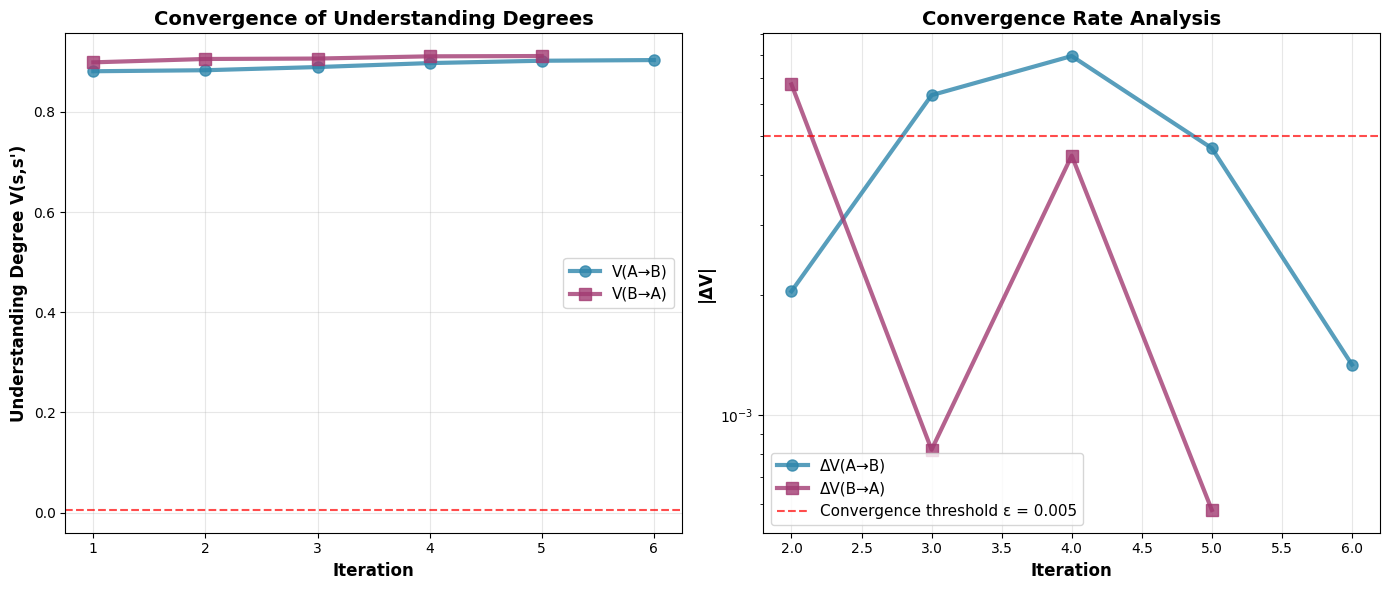

In [17]:
# Plot detailed convergence analysis
_ = plot_convergence_analysis(results, save_path=f"{path}/rc_convergence_analysis", show_plot=False)

Timeline plot saved to results-gpt-4.1-mini-o4-mini-1755041911.4850502/rc_timeline_analysis_timeline_AB.png


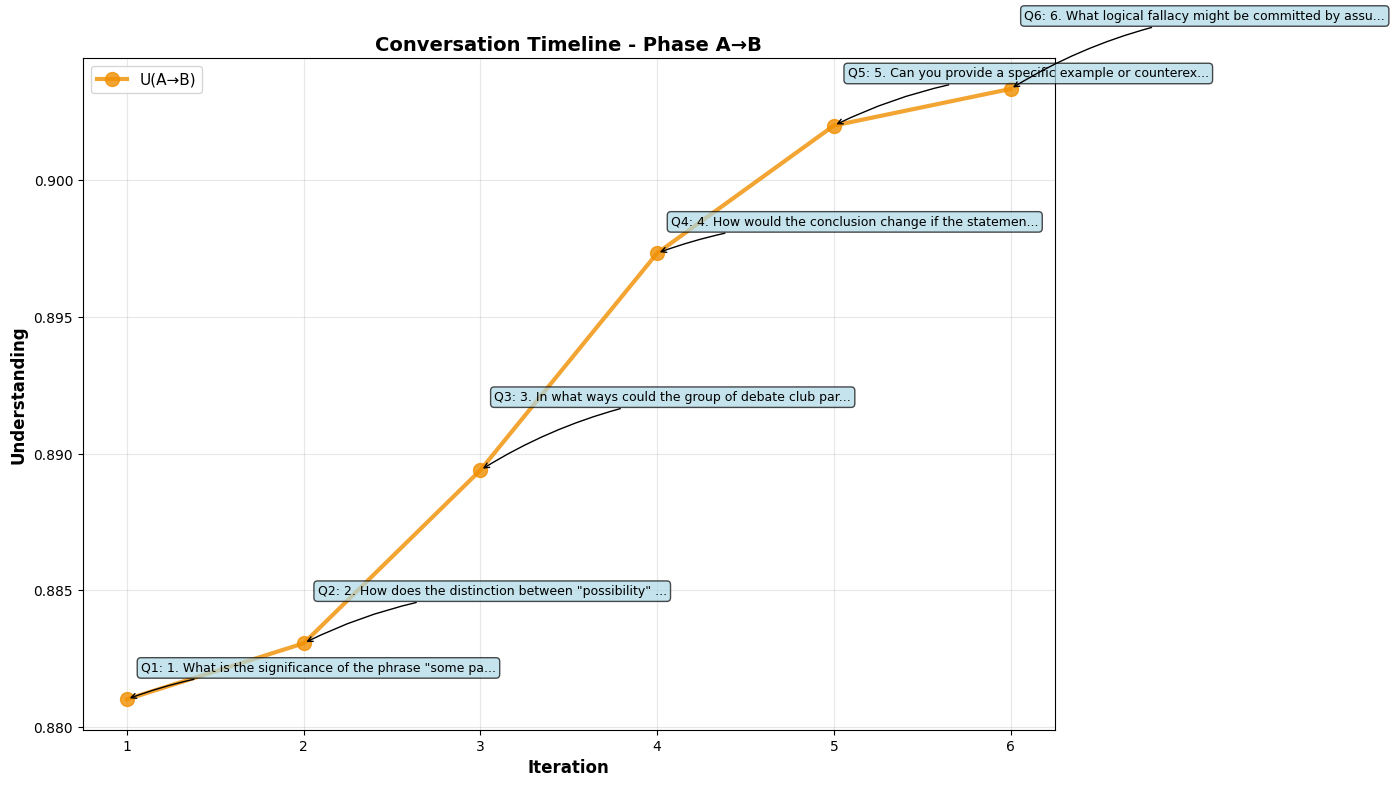

In [18]:
# Plot conversation timeline for phase A→B
_ = plot_conversation_timeline(results, phase='AB', save_path=f"{path}/rc_timeline_analysis", show_plot=False)

Timeline plot saved to results-gpt-4.1-mini-o4-mini-1755041911.4850502/rc_timeline_analysis_timeline_BA.png


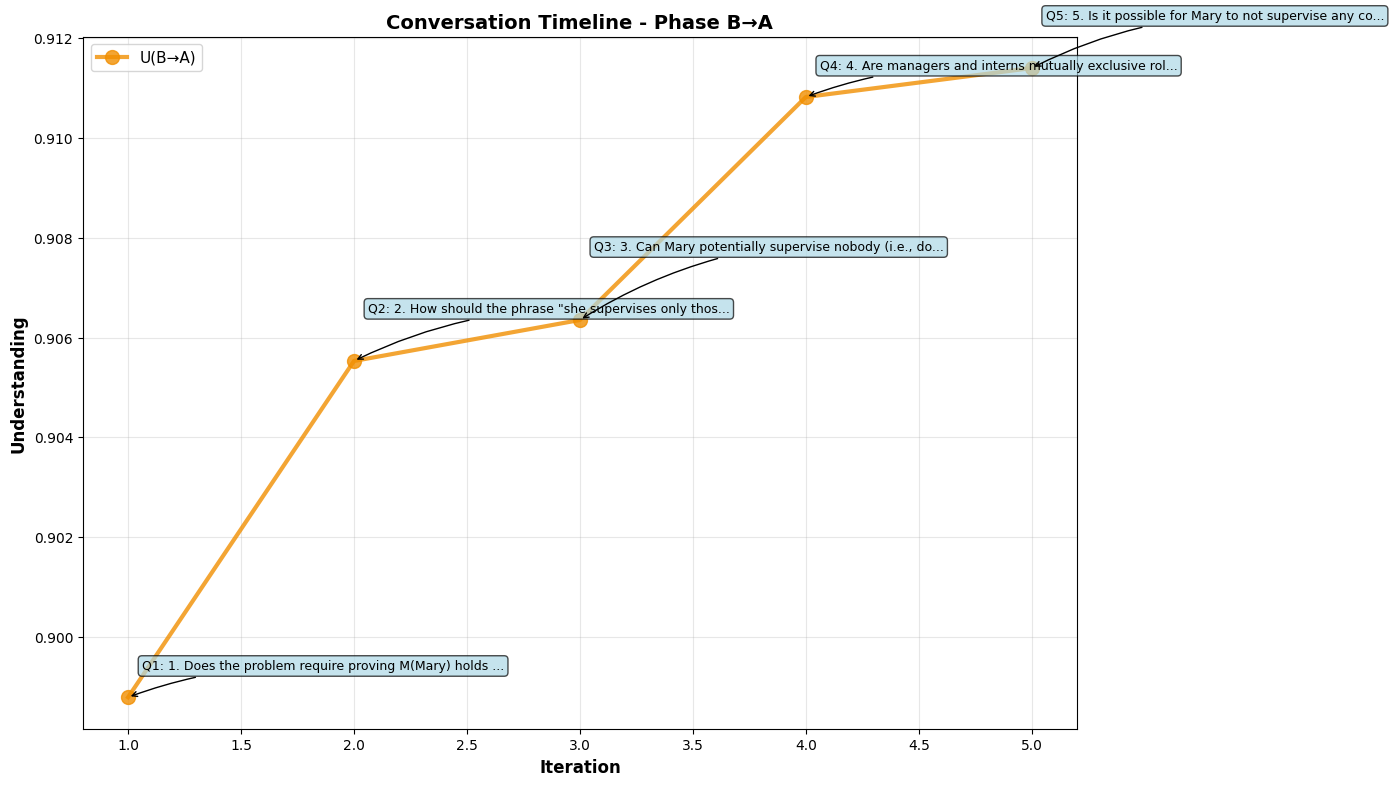

In [19]:
# Plot conversation timeline for phase B→A
_ = plot_conversation_timeline(results, phase='BA', save_path=f"{path}/rc_timeline_analysis", show_plot=True)

Comprehensive plot saved to results-gpt-4.1-mini-o4-mini-1755041911.4850502/rc_comprehensive_analysis_comprehensive.png


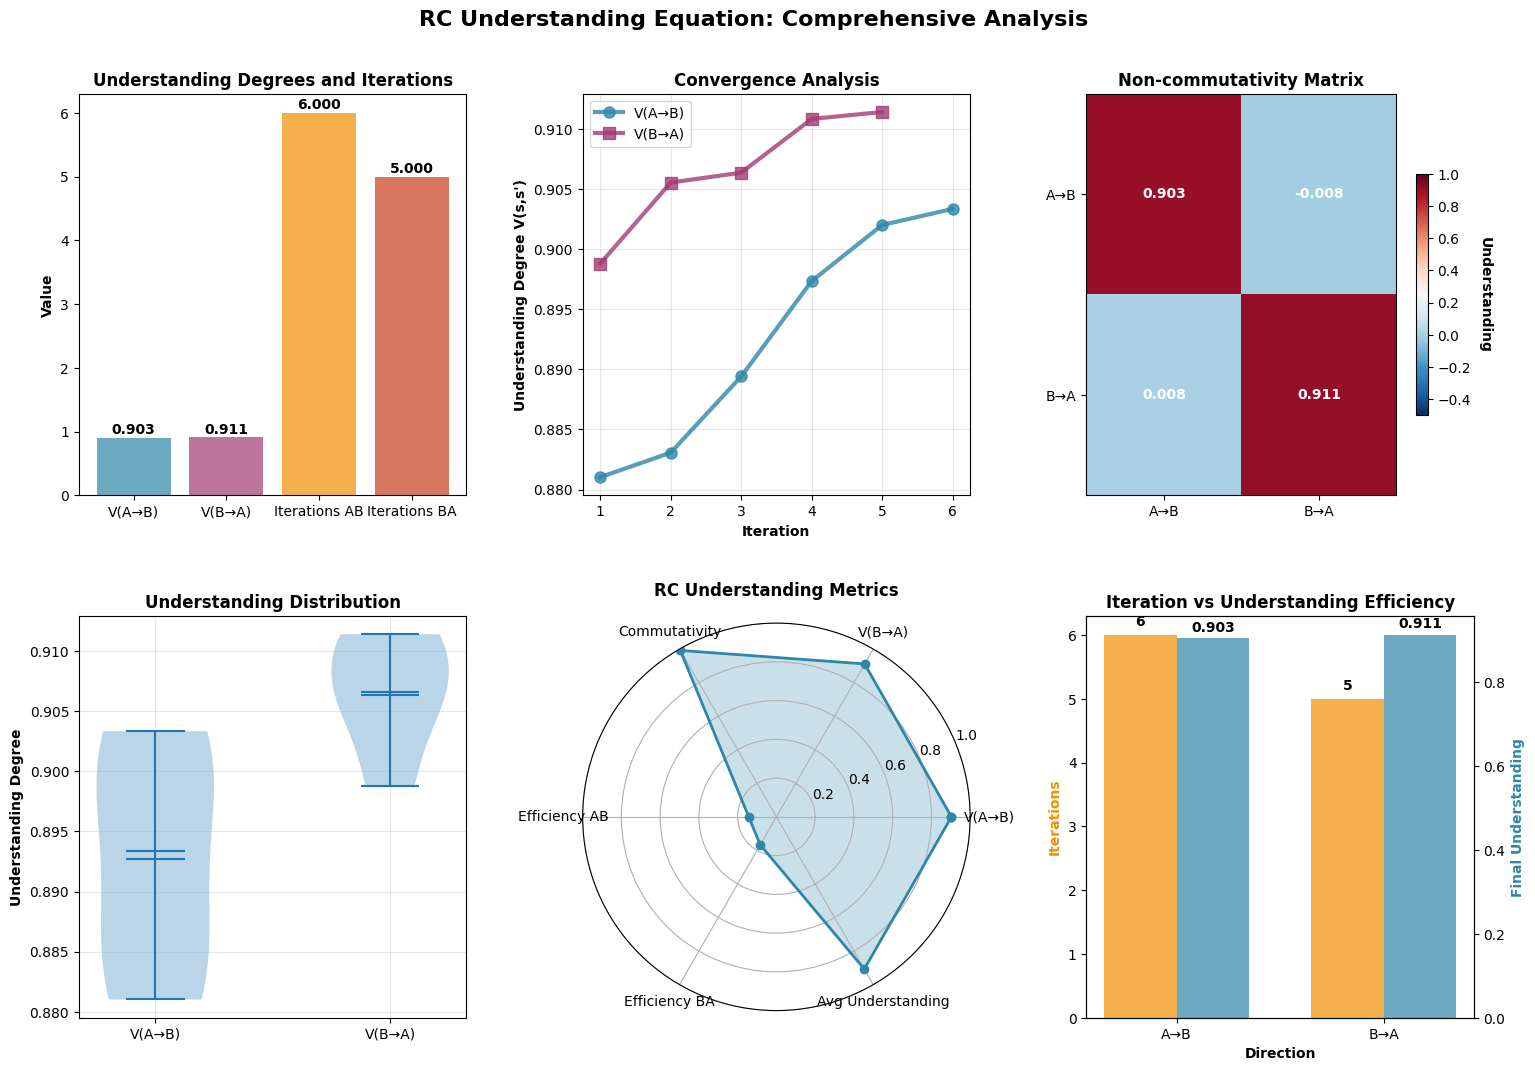

In [20]:
# Plot comprehensive experiment results with all statistical charts
_ = plot_experiment_results(results, save_path=f"{path}/rc_comprehensive_analysis", show_plots=True)